# Wetland species dataset  notebook

The data was downloaded from [here](https://hive.utah.edu/concern/datasets/1z40ks82j?).

Troy M. Saltiel, Philip E. Dennison, Michael J. Campbell, Tom R. Thompson and Keith R. Hambrecht. [*Tradeoffs between UAS Spatial Resolution and Accuracy for Deep Learning Semantic Segmentation Applied to Wetland Vegetation Species Mapping*](https://doi.org/10.3390/rs14112703). **Remote Sensing, 14(11)**. (2022)

## Class description:
- **Label: 0** (Phragmites australis)
- **Label: 1** (Cattail)
- **Label: 2** (Water)
- **Label: 3** (Non-Photosynthetic Material)
- **Label: 4** (Algae)
- **Label: 5** (Bulrush)

## Channel description:

- **Channel: 1** (Blue - B)
- **Channel: 2** (Green - G)
- **Channel: 3** (Red - R)
- **Channel: 4** (Red-Edge)
- **Channel: 5** (Near-Infrared)

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image
import tifffile as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import MosaicDataset, BalancedMosaicDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Data preparation
This is a structured dataset where a set of image mosaics (with 5 bands) and a set of masks (6 classes) are stored in TIFF files. While the original paper provided the original images and tools to reconstruct the mosaics, we decided to use the mosaics to have a more uniform and fair comparison between datasets. There were also some issues downloading the original images.

Due to the simplicity of the dataset, only the paths and filenames are defined on the following cell.

In [2]:
d_path = '/home/mariano/data/Wetlands/Saltiel'
mosaic_path = os.path.join(d_path, 'mosaics')
annot_path = os.path.join(d_path, 'annotations')
training_mosaic_file = 'FFSL_zone_000_original_train_image_1.tif'
training_labels_file = 'FFSL_zone_000_original_train_labels_1.tiff'
val_mosaic_file = 'FFSL_zone_000_original_validation_close.tif'
val_labels_file = 'FFSL_zone_000_original_validation_labels_close.tiff'

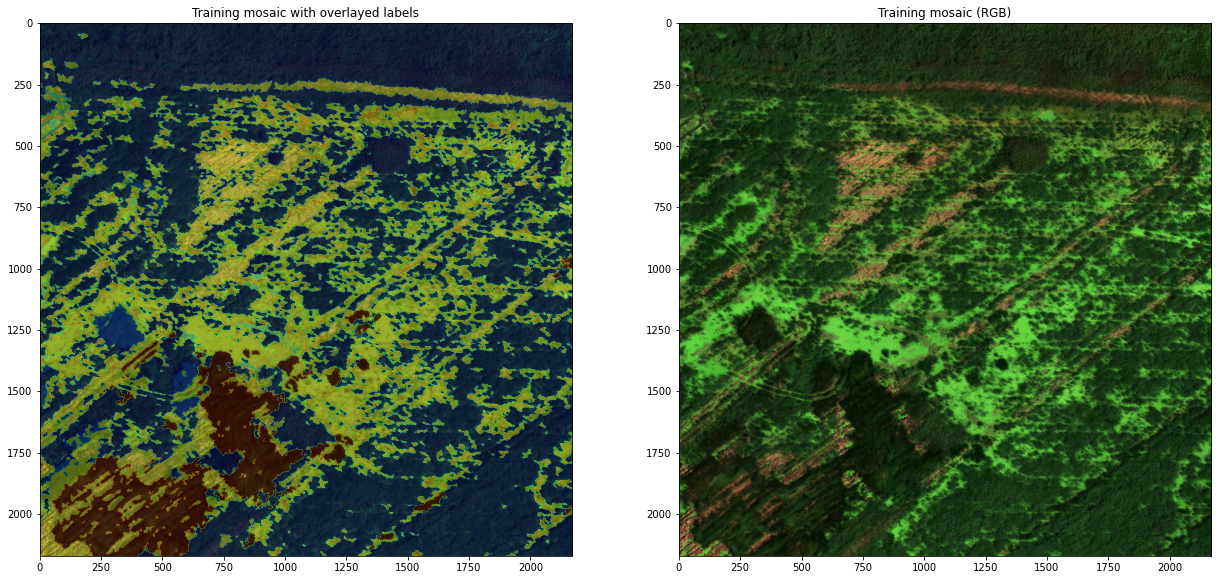

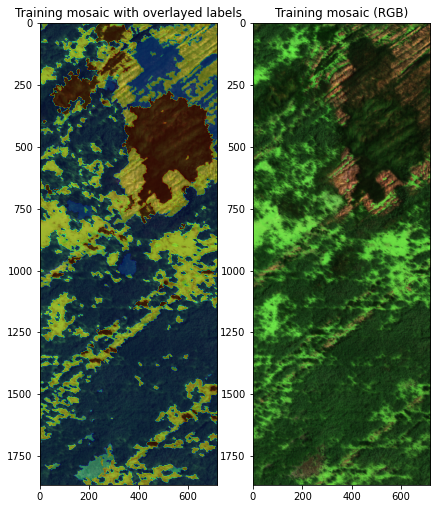

In [3]:
training_mosaic = np.array(tf.imread(os.path.join(mosaic_path, training_mosaic_file)))
training_mask = np.array(tf.imread(os.path.join(annot_path, training_labels_file)))
training_mask = np.clip(training_mask, 0, 5)

testing_mosaic = np.array(tf.imread(os.path.join(mosaic_path, val_mosaic_file)))
testing_mask = np.array(tf.imread(os.path.join(annot_path, val_labels_file)))
testing_mask = np.clip(testing_mask, 0, 5)

im_y, im_x, _ = training_mosaic.shape

c0 = training_mosaic[..., 0]
c0[c0 < 0] = 0
c1 = training_mosaic[..., 1]
c1[c1 < 0] = 0
c2 = training_mosaic[..., 2]
c2[c2 < 0] = 0
c3 = training_mosaic[..., 2]
c3[c3 < 0] = 0
c4 = training_mosaic[..., 2]
c4[c4 < 0] = 0

plt.figure(figsize=(im_x // 100, im_y // 200))
plt.subplot(1, 2, 1)
plt.imshow(
    np.stack([
        c2 / np.max(training_mosaic[..., :3]),
        c1 / np.max(training_mosaic[..., :3]),
        c0 / np.max(training_mosaic[..., :3])
    ], axis=-1)
)
plt.imshow(np.clip(training_mask, 0, 5) / 5, alpha=0.33, cmap='jet')
plt.title('Training mosaic with overlayed labels')

plt.subplot(1, 2, 2)
plt.imshow(
    np.stack([
        c2 / np.max(training_mosaic[..., :3]),
        c1 / np.max(training_mosaic[..., :3]),
        c0 / np.max(training_mosaic[..., :3])
    ], axis=-1)
)
plt.title('Training mosaic (RGB)')
training_mosaic = np.stack([c2, c1, c0, c3, c4], axis=-1)

c0 = testing_mosaic[..., 0]
c0[c0 < 0] = 0
c1 = testing_mosaic[..., 1]
c1[c1 < 0] = 0
c2 = testing_mosaic[..., 2]
c2[c2 < 0] = 0
c3 = testing_mosaic[..., 2]
c3[c3 < 0] = 0
c4 = testing_mosaic[..., 2]
c4[c4 < 0] = 0

im_y, im_x, _ = testing_mosaic.shape

plt.figure(figsize=(im_x // 100, im_y // 200))
plt.subplot(1, 2, 1)
plt.imshow(
    np.stack([
        c2 / np.max(testing_mosaic[..., :3]),
        c1 / np.max(testing_mosaic[..., :3]),
        c0 / np.max(testing_mosaic[..., :3])
    ], axis=-1)
)
plt.imshow(np.clip(testing_mask, 0, 5) / 5, alpha=0.33, cmap='jet')
plt.title('Training mosaic with overlayed labels')

plt.subplot(1, 2, 2)
plt.imshow(
    np.stack([
        c2 / np.max(testing_mosaic[..., :3]),
        c1 / np.max(testing_mosaic[..., :3]),
        c0 / np.max(testing_mosaic[..., :3])
    ], axis=-1)
)
plt.title('Training mosaic (RGB)')
testing_mosaic = np.stack([c2, c1, c0, c3, c4], axis=-1)

# Main function
The following cell contains the main function that will be used to run all the experiments for the dataset.

```python
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore, a **network_name** is required for the weights file while a **display_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained. The **classes** variable with a list of the class names and the **experiment_name** variables are also used to display messages regarding the results and experiment type.

For training and testing, a tuple of lists containing the mosaics and masks are required as **training_data** and **testing_data** for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [4]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
):
    # Init
    training_mosaics, training_masks = training_data
    testing_mosaics, testing_masks = testing_data
    
    # While we use a BalancedMosaicDataset for training, it might
    # be a good idea to also use MosaicDataset. The choice of dataset
    # should be coherent with what we do on the other datasets.  
    training_set = BalancedMosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    validation_set = MosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            mosaic_dsc = []
            mosaic_class_dsc = []
            # Intermediate buffers for class metrics.
            for input_mosaic, mask_i in zip(testing_mosaics, testing_masks):
                pred_map = net.patch_inference(
                    normalise(input_mosaic).astype(np.float32),
                    patch_size, test_batch
                )
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                mosaic_dsc.append(dsc)
                mosaic_class_dsc.append(dsc_k.tolist())

                for i, map_i in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map_{:02d}.png'.format(
                            network_name, seed, i
                        )
                    )
                    final_map = (255 * map_i).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks.png'.format(
                        network_name, seed
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(mosaic_dsc, axis=0)
                class_dsc = np.nanmean(mosaic_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(mosaic_dsc)
        class_dsc_list.append(mosaic_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 32
test_batch = 64
patch_size = 128
overlap = 16
epochs = 50
patience = 50
name = 'wetland species'
classes = [
    'Phragmites australis', 'Cattail', 'Water',
    'Non-Photosynthetic Material', 'Algae', 'Bulrush'
]

image_path = os.path.join(
    d_path, 'Predictions', 'testing_image.png'
)
mosaic_rgb = testing_mosaic[..., :3]
skio.imsave(
    image_path, 
    (255 * (mosaic_rgb / np.max(mosaic_rgb))).astype(np.uint8)
)
mask_path = os.path.join(
    d_path, 'Predictions', 'testing_mask.png'
)
skio.imsave(mask_path, (255 * (testing_mask / 5)).astype(np.uint8))

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
training_set = ([np.moveaxis(training_mosaic, -1, 0)], [training_mask])
testing_set = ([np.moveaxis(testing_mosaic, -1, 0)], [testing_mask])
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Unet [64, 64, 256, 256, 512, 512]
    unet_dsc, unet_k_dsc = run_segmentation_experiments(
        master_seed, 'unet2d', 'Unet 2D', name,
        partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet50
    fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
        partial(FCN_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet101
    fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
        partial(FCN_ResNet101, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # DeeplapV3 MobileNet
    dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
        partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # DeeplapV3 ResNet50
    dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
        partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # L-RASPP ResNet50
    lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
        master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
        partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

[11/18/2023 - 10:36:11] Unet 2D Mean DSC 0.515                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[11/18/2023 - 10:36:11] Unet 2D Mean class DSC Phragmites australis 0.904, Cattail 0.022, Water 0.000, Non-Photosynthetic Material 0.651, Algae 0.813, Bulrush 0.702
[11/18/2023 - 10:40:32] FCN ResNet50 Mean DSC 0.522                                                                                                                                                                                                                                  

           Epoch 020 |  0.4502 |  0.4512 |   0.4512 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4300 |  0.4463 |   0.4463 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2512 |  0.2631 |   0.2631 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2549 |  0.2592 |   0.2592 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4366 |  0.4264 |   0.4264 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4073 |  0.4153 |   0.4153 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2427 |  0.2558 |   0.2558 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2431 |  0.2536 |   0.2536 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4270 |  0.4301 |   0.4301 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4090 |  0.4202 |   0.4202 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2538 |  0.2633 |   0.2633 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2434 |  0.2648 |   0.2648 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4182 |  0.4300 |   0.4300 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4152 |  0.4148 |   0.4148 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2447 |  0.2525 |   0.2525 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2329 |  0.2481 |   0.2481 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4184 |  0.4331 |   0.4331 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4110 |  0.4201 |   0.4201 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2396 |  0.2519 |   0.2519 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 047 |  0.2402 |  0.2448 |   0.2448 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 020 |  0.4311 |  0.4181 |   0.4181 |   0.0000 |   0.0000 | 0.000 | 5s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4122 |  0.4156 |   0.4156 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2391 |  0.2553 |   0.2553 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 047 |  0.2488 |  0.2469 |   0.2469 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 020 |  0.4383 |  0.4377 |   0.4377 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 021 |  0.4072 |  0.4184 |   0.4184 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 046 |  0.2384 |  0.2498 |   0.2498 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2515 |  0.2516 |   0.2516 |   0.0000 |   0.0000 | 0.000 | 7s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4716 |  0.5103 |   0.5103 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 021 |  0.4748 |  0.4769 |   0.4769 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                      

           Epoch 046 |  0.2732 |  0.2802 |   0.2802 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 047 |  0.2612 |  0.2701 |   0.2701 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                             

           Epoch 020 |  0.4417 |  0.4725 |   0.4725 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4294 |  0.4424 |   0.4424 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2466 |  0.2594 |   0.2594 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2401 |  0.2501 |   0.2501 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4642 |  0.4610 |   0.4610 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4444 |  0.4538 |   0.4538 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2595 |  0.2673 |   0.2673 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2625 |  0.2644 |   0.2644 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4841 |  0.4858 |   0.4858 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4499 |  0.4635 |   0.4635 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2701 |  0.2670 |   0.2670 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2560 |  0.2684 |   0.2684 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4483 |  0.4347 |   0.4347 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4221 |  0.4352 |   0.4352 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2452 |  0.2527 |   0.2527 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2331 |  0.2513 |   0.2513 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4619 |  0.4652 |   0.4652 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4580 |  0.4660 |   0.4660 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2673 |  0.2714 |   0.2714 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2572 |  0.2638 |   0.2638 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4404 |  0.5306 |   0.4572 |   0.0734 |   0.0861 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 021 |  0.4408 |  0.4496 |   0.4496 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 046 |  0.2506 |  0.2562 |   0.2562 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2539 |  0.2540 |   0.2540 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4233 |  0.4249 |   0.4249 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.3950 |  0.4116 |   0.4116 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2522 |  0.2430 |   0.2430 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2439 |  0.2458 |   0.2458 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4635 |  0.4420 |   0.4420 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 021 |  0.4384 |  0.4469 |   0.4469 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 046 |  0.2461 |  0.2547 |   0.2547 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2572 |  0.2500 |   0.2500 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4433 |  0.4461 |   0.4461 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4378 |  0.4401 |   0.4401 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2545 |  0.2631 |   0.2631 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2570 |  0.2628 |   0.2628 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4355 |  0.4420 |   0.4420 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4241 |  0.4286 |   0.4286 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2460 |  0.2527 |   0.2527 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2464 |  0.2510 |   0.2510 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4433 |  0.5328 |   0.4455 |   0.0872 |   0.0965 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 021 |  0.4173 |  0.5939 |   0.4339 |   0.1600 |   0.1821 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 046 |  0.2508 |  0.2570 |   0.2570 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2489 |  0.2498 |   0.2498 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4043 |  0.4170 |   0.4170 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4245 |  0.3975 |   0.3975 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2504 |  0.2446 |   0.2446 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2414 |  0.2431 |   0.2431 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4597 |  0.4640 |   0.4640 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4360 |  0.4493 |   0.4493 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2543 |  0.2677 |   0.2677 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2545 |  0.2573 |   0.2573 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4521 |  0.4413 |   0.4413 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 021 |  0.4222 |  0.4357 |   0.4357 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 046 |  0.2500 |  0.2526 |   0.2526 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2387 |  0.2480 |   0.2480 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4483 |  0.4550 |   0.4550 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4413 |  0.4433 |   0.4433 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2529 |  0.2601 |   0.2601 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2615 |  0.2581 |   0.2581 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4201 |  0.4268 |   0.4268 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4086 |  0.4223 |   0.4223 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2371 |  0.2501 |   0.2501 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2354 |  0.2455 |   0.2455 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4657 |  0.4543 |   0.4543 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4406 |  0.4407 |   0.4407 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2630 |  0.2607 |   0.2607 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
           Epoch 047 |  0.2598 |  0.2577 |   0.2577 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                             

           Epoch 020 |  0.4507 |  0.4433 |   0.4433 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 021 |  0.4211 |  0.4350 |   0.4350 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 046 |  0.2553 |  0.2559 |   0.2559 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2397 |  0.2498 |   0.2498 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4203 |  0.4112 |   0.4112 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 021 |  0.4024 |  0.3988 |   0.3988 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 046 |  0.2434 |  0.2459 |   0.2459 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 047 |  0.2329 |  0.2450 |   0.2450 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 020 |  0.4352 |  0.5176 |   0.4452 |   0.0724 |   0.0854 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 021 |  0.4307 |  0.4454 |   0.4454 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 046 |  0.2445 |  0.2557 |   0.2557 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2500 |  0.2514 |   0.2514 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4588 |  0.5204 |   0.4505 |   0.0699 |   0.0827 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 021 |  0.4475 |  0.5129 |   0.4408 |   0.0721 |   0.0849 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                               

           Epoch 046 |  0.2479 |  0.2630 |   0.2630 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2541 |  0.2591 |   0.2591 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 020 |  0.4679 |  0.4713 |   0.4713 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 021 |  0.4731 |  0.4514 |   0.4514 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 046 |  0.2544 |  0.2593 |   0.2593 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 047 |  0.2585 |  0.2600 |   0.2600 |   0.0000 |   0.0000 | 0.000 | 4s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.5803 |  0.6972 |   0.6972 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.5824 |  0.6762 |   0.6762 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4040 |  0.4193 |   0.4193 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4190 |  0.4156 |   0.4156 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6876 |  0.9539 |   0.7423 |   0.2115 |   0.2316 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6437 |  0.9158 |   0.7078 |   0.2081 |   0.2291 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4321 |  0.4492 |   0.4492 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4551 |  0.4471 |   0.4471 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6598 |  1.2703 |   0.8020 |   0.4683 |   0.4981 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6459 |  1.2407 |   0.7780 |   0.4627 |   0.4927 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4294 |  0.4686 |   0.4686 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4621 |  0.4646 |   0.4646 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6227 |  0.9276 |   0.7240 |   0.2036 |   0.2267 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
           Epoch 020 |  0.6132 |  0.8015 |   0.7022 |   0.0993 |   0.1111 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                               

           Epoch 045 |  0.4324 |  0.5196 |   0.4342 |   0.0854 |   0.0990 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4197 |  0.4301 |   0.4301 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6325 |  0.7663 |   0.7663 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.6225 |  0.7438 |   0.7438 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4171 |  0.4452 |   0.4452 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4173 |  0.4379 |   0.4379 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.5943 |  0.6890 |   0.6890 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 020 |  0.5454 |  0.6663 |   0.6663 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 045 |  0.4008 |  0.5001 |   0.4131 |   0.0870 |   0.0979 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 046 |  0.3836 |  0.4095 |   0.4095 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 019 |  0.6938 |  0.8673 |   0.7521 |   0.1152 |   0.1241 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6250 |  0.7269 |   0.7269 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4291 |  0.4613 |   0.4613 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4416 |  0.4549 |   0.4549 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6296 |  0.7204 |   0.7204 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.6232 |  0.7011 |   0.7011 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4196 |  0.4314 |   0.4314 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4093 |  0.4269 |   0.4269 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6237 |  0.7288 |   0.7288 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.6132 |  0.7035 |   0.7035 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4147 |  0.4351 |   0.4351 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4144 |  0.4299 |   0.4299 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6093 |  0.7047 |   0.7047 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6304 |  0.6913 |   0.6913 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4319 |  0.4481 |   0.4481 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4114 |  0.4441 |   0.4441 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6046 |  0.6760 |   0.6760 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.5899 |  0.6613 |   0.6613 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4038 |  0.4331 |   0.4331 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4100 |  0.4281 |   0.4281 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6495 |  0.8091 |   0.8091 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6460 |  0.7894 |   0.7894 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4150 |  0.4486 |   0.4486 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4106 |  0.4427 |   0.4427 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6006 |  0.8104 |   0.7004 |   0.1100 |   0.1199 | 0.000 | 0s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
           Epoch 020 |  0.5668 |  0.7928 |   0.6849 |   0.1079 |   0.1182 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                      

           Epoch 045 |  0.3940 |  0.4256 |   0.4256 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.3835 |  0.4218 |   0.4218 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6897 |  0.8996 |   0.7922 |   0.1074 |   0.1189 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6664 |  0.8737 |   0.7686 |   0.1051 |   0.1168 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4238 |  0.4479 |   0.4479 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4331 |  0.4416 |   0.4416 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6053 |  0.8473 |   0.7321 |   0.1151 |   0.1230 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6013 |  0.8256 |   0.7109 |   0.1147 |   0.1228 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4294 |  0.4328 |   0.4328 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4075 |  0.4273 |   0.4273 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6183 |  0.7809 |   0.7809 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.6252 |  0.8482 |   0.7516 |   0.0967 |   0.1068 | 0.000 | 0s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4310 |  0.4395 |   0.4395 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4238 |  0.4357 |   0.4357 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6386 |  1.0124 |   0.7634 |   0.2491 |   0.2610 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6460 |  0.9837 |   0.7433 |   0.2405 |   0.2537 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4332 |  0.4478 |   0.4478 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4294 |  0.4428 |   0.4428 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6167 |  0.6679 |   0.6679 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.5862 |  0.6502 |   0.6502 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4270 |  0.4211 |   0.4211 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4065 |  0.4170 |   0.4170 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6629 |  1.0957 |   0.7454 |   0.3503 |   0.3747 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6680 |  0.9494 |   0.7272 |   0.2221 |   0.2406 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4459 |  0.4629 |   0.4629 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4449 |  0.4570 |   0.4570 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6569 |  1.0224 |   0.7837 |   0.2387 |   0.2499 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6278 |  1.0075 |   0.7691 |   0.2384 |   0.2493 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4276 |  0.4414 |   0.4414 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4192 |  0.4364 |   0.4364 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6527 |  1.0975 |   0.7423 |   0.3553 |   0.3770 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6267 |  0.9477 |   0.7139 |   0.2339 |   0.2474 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4270 |  0.4554 |   0.4554 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4164 |  0.4467 |   0.4467 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6324 |  1.1146 |   0.7310 |   0.3837 |   0.3998 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.6209 |  1.0967 |   0.7153 |   0.3813 |   0.3981 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4101 |  0.4399 |   0.4399 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4271 |  0.4333 |   0.4333 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6624 |  0.9191 |   0.7967 |   0.1224 |   0.1284 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6397 |  0.8945 |   0.7722 |   0.1224 |   0.1283 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4355 |  0.4616 |   0.4616 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4236 |  0.4548 |   0.4548 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6873 |  0.9307 |   0.8027 |   0.1280 |   0.1320 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6598 |  0.9080 |   0.7801 |   0.1279 |   0.1319 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4347 |  0.4660 |   0.4660 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4141 |  0.4575 |   0.4575 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.5969 |  1.1546 |   0.7088 |   0.4458 |   0.4828 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 020 |  0.5549 |  0.9079 |   0.6848 |   0.2231 |   0.2411 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 045 |  0.4034 |  0.4236 |   0.4236 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.3962 |  0.4183 |   0.4183 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6321 |  0.7517 |   0.7517 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 020 |  0.5753 |  0.7316 |   0.7316 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 045 |  0.4175 |  0.4357 |   0.4357 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.3964 |  0.4328 |   0.4328 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.5950 |  0.7952 |   0.6929 |   0.1023 |   0.1128 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
           Epoch 020 |  0.5859 |  0.7728 |   0.6711 |   0.1017 |   0.1122 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                          

           Epoch 045 |  0.4010 |  0.4198 |   0.4198 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 046 |  0.4017 |  0.4171 |   0.4171 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 019 |  0.6267 |  0.7326 |   0.7326 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
           Epoch 020 |  0.6086 |  0.7165 |   0.7165 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                        

           Epoch 045 |  0.3989 |  0.4385 |   0.4385 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4092 |  0.4339 |   0.4339 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6555 |  0.7101 |   0.7101 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 020 |  0.6145 |  0.6877 |   0.6877 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 045 |  0.4320 |  0.4361 |   0.4361 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4123 |  0.4328 |   0.4328 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

           Epoch 019 |  0.6549 |  0.9253 |   0.8117 |   0.1137 |   0.1223 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
           Epoch 020 |  0.6562 |  0.9001 |   0.7870 |   0.1131 |   0.1217 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                   

           Epoch 045 |  0.4303 |  0.4384 |   0.4384 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
           Epoch 046 |  0.4133 |  0.4334 |   0.4334 |   0.0000 |   0.0000 | 0.000 | 1s                                                                                                                                                                                                                                                                                                                                                                 

# Main functions (classification)
The following cell contains two main functions that will be used to run all the experiments for the dataset.

```python
def attribution(x, attr_m, *args, **kwargs)
```

This first function is used as a wrapper for the generation a final saliency map based on the output of the relevant Captum method and the input image (**x**). Depending on the attribution method, the map might be unbounded or have a different size than the original image. To fix that and provide a storable image, this function makes the necessary transformations.

Since the function acts as a wrapper and the attribution method (**attr_m**) might require additional parameters, we need **args** and **kwargs** as input parameters that are then passed to the attribution method as either a list or a dictionary of arguments, respectively.

```python
def run_experiments(
    master_seed, network_name, network, training_files, testing_files, weight_path, maps_path,
    patch_size=256, epochs=10, patience=5, n_seeds=30, n_classes=2, train_batch=20,
    test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore a **network_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained, together with the required lists of **training_files** and **testing_files** with the name of the images containing the mosaic for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.